#The implementation of different LSTM models including Encoder-Decoder based approaches for Rainfall-Runoff Modeling for Awash River in Ethiopia.


The data used to model the system are the streamflow, precipitation, temperature, wind speed, and humudity at different guaging stations in the upper Awash river basin. 28 years of daily recorded data is used.

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


# Import Libraries

In [2]:
import pandas as pd
import datetime as dt  # Python standard library datetime  module
import matplotlib.pyplot as plt
import keras
from pandas import read_csv,concat,DataFrame,datetime
import numpy
import numpy as np
from numpy import concatenate
from statsmodels.graphics.tsaplots import plot_acf


import statsmodels
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
import matplotlib as mpl
import scipy.stats as ss

import math
from math import sqrt

from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,mean_squared_error,mean_absolute_error

from tensorflow.keras import regularizers,optimizers
from tensorflow.keras.layers import BatchNormalization,Dense, Dropout, LSTM, Bidirectional, GRU, TimeDistributed, Input, RNN,GRUCell,Lambda
from tensorflow.keras.models import Sequential,Model
from keras.callbacks import Callback,ReduceLROnPlateau

from tensorflow.keras import backend as K

from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [3]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
tf.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.8.2'

In [ ]:
tf.test.is_gpu_available()    #Tru if Gpu is avalible

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
!cat /proc/cpuinfo # Check the processing hardware

#Data preparation and processing

The Path below goes to my mounted GoogleDrive - It should be changed based on your GoogleDrive directory.

In [4]:
path= "/content/drive/MyDrive/1981_final/"

In [ ]:
!ls

drive  sample_data


The Datasets were slightly modified before uploading them.

1) Missing data was replaced by taking the average of previous 3 years on similar date of record.

#Stream flow data for 3 stations 1) Berga station 2)Akaki Station 3) Hombole station (this is the target station to predict future streamflow)

In [5]:
sf_berga = pd.read_csv(path + 'berga.csv')
sf_akaki = pd.read_csv(path + 'Akaki.csv')
sf_hom = pd.read_csv(path + 'hombole.csv')

#Precipitation at 11 stations 1) Addis ababa 2) Hombole 3) Asgori 4) Sendefa 5) Tulubolo 6)Sebeta 7)Addis Alem 8) Boneya 9) Kimoye 10) Guranda 11) Ginchi

In [6]:
pcp_aa = pd.read_csv(path + 'pcp_aa.csv') # preciptation at addis ababa station
pcp_hom = pd.read_csv(path + 'pcp_hom.csv') # preciptation at hombole station
pcp_asgori = pd.read_csv(path + 'pcp_asgori.csv') # preciptation at asgori station
pcp_sendefa = pd.read_csv(path + 'pcp_sendefa.csv') # preciptation at sendefa station
pcp_tulubolo = pd.read_csv(path + 'pcp_tulubolo.csv') # preciptation at tulubolo station

pcp_sebeta = pd.read_csv(path + 'pcp_sebeta.csv') # preciptation at sebeta station
pcp_aalem = pd.read_csv(path + 'pcp_aalem.csv') # preciptation at addis alem station
pcp_boneya = pd.read_csv(path + 'pcp_boneya.csv') # preciptation at boneya station
pcp_kimoye = pd.read_csv(path + 'pcp_kimoye.csv') # preciptation at kimoye station
pcp_guranda = pd.read_csv(path + 'pcp_guranda.csv') # preciptation at guranda meta station

pcp_ginchi = pd.read_csv(path + 'pcp_ginchi.csv') # preciptation at ginchi station

#Average of (min and max) temprature at 11 stations 1) Addis ababa 2) Hombole 3) Asgori 4) Sendefa 5) Tulubolo 6)Sendefa 7)Addis Alem 8) Boneya 9) Kimoye 10) Guranda 11)11) Ginchi

In [7]:
temp_aa = pd.read_csv(path + 'tmp_aa.csv') # temprature at addis ababa station
temp_hom = pd.read_csv(path + 'tmp_hom.csv') # preciptation at hombole station
temp_asgori = pd.read_csv(path + 'tmp_asgori.csv') # preciptation at asgori station
temp_sendefa = pd.read_csv(path + 'tmp_sendefa.csv') # preciptation at sendefa station
temp_tulubolo = pd.read_csv(path + 'tmp_tulubolo.csv') # preciptation at tulubolo station

temp_sebeta = pd.read_csv(path + 'tmp_sebeta.csv') # preciptation at sebeta station
temp_aalem = pd.read_csv(path + 'tmp_aalem.csv') # preciptation at addis alem station
temp_boneya = pd.read_csv(path + 'tmp_boneya.csv') # preciptation at boneya station
temp_kimoye = pd.read_csv(path + 'tmp_kimoye.csv') # preciptation at kimoye station
temp_guranda = pd.read_csv(path + 'tmp_guranda.csv') # preciptation at guranda meta station

temp_ginchi = pd.read_csv(path + 'tmp_ginchi.csv') # preciptation at ginchi station

In [8]:
temp_hom.head()

,DATE,avg_temp
0,1/1/1981,20.20
1,1/2/1981,20.10
2,1/3/1981,20.10
3,1/4/1981,20.15
4,1/5/1981,20.75


#Humudity at 11 stations 1) Addis ababa 2) Hombole 3) Asgori 4) Sendefa 5) Tulubolo 6)Sendefa 7)Addis Alem 8) Boneya 9) Kimoye 10) Guranda 11)11) Ginchi

In [9]:
hmd_aa = pd.read_csv(path + 'hmd_aa.csv') # humudity at addis ababa station
hmd_hom = pd.read_csv(path + 'hmd_hom.csv') # preciptation at hombole station
hmd_asgori = pd.read_csv(path + 'hmd_asgori.csv') # preciptation at asgori station
hmd_sendefa = pd.read_csv(path + 'hmd_sendefa.csv') # preciptation at sendefa station
hmd_tulubolo = pd.read_csv(path + 'hmd_tulubolo.csv') # preciptation at tulubolo station

hmd_sebeta = pd.read_csv(path + 'hmd_sebeta.csv') # preciptation at sebeta station
hmd_aalem = pd.read_csv(path + 'hmd_aalem.csv') # preciptation at addis alem station
hmd_boneya = pd.read_csv(path + 'hmd_boneya.csv') # preciptation at boneya station
hmd_kimoye = pd.read_csv(path + 'hmd_kimoye.csv') # preciptation at kimoye station
hmd_guranda = pd.read_csv(path + 'hmd_guranda.csv') # preciptation at guranda meta station

hmd_ginchi = pd.read_csv(path + 'hmd_ginchi.csv') # preciptation at ginchi station

#Wind Speed at 11 stations 1) Addis ababa 2) Hombole 3) Asgori 4) Sendefa 5) Tulubolo 6)Sendefa 7)Addis Alem 8) Boneya 9) Kimoye 10) Guranda 11)11) Ginchi

In [10]:
wnd_aa = pd.read_csv(path + 'wnd_aa.csv') # wind speed at addis ababa station
wnd_hom = pd.read_csv(path + 'wnd_hom.csv') # preciptation at hombole station
wnd_asgori = pd.read_csv(path + 'wnd_asgori.csv') # preciptation at asgori station
wnd_sendefa = pd.read_csv(path + 'wnd_sendefa.csv') # preciptation at sendefa station
wnd_tulubolo = pd.read_csv(path + 'wnd_tulubolo.csv') # preciptation at tulubolo station

wnd_sebeta = pd.read_csv(path + 'wnd_sebeta.csv') # preciptation at sebeta station
wnd_aalem = pd.read_csv(path + 'wnd_aalem.csv') # preciptation at addis alem station
wnd_boneya = pd.read_csv(path + 'wnd_boneya.csv') # preciptation at boneya station
wnd_kimoye = pd.read_csv(path + 'wnd_kimoye.csv') # preciptation at kimoye station
wnd_guranda = pd.read_csv(path + 'wnd_guranda.csv') # preciptation at guranda meta station

wnd_ginchi = pd.read_csv(path + 'wnd_ginchi.csv') # preciptation at ginchi station

#Make date as index

In [11]:
## format datetime column
sf_hom["date"] = pd.to_datetime(sf_hom['date'])
sf_hom = sf_hom.set_index(['date'])
sf_berga["date"] = pd.to_datetime(sf_berga['date'])
sf_berga = sf_berga.set_index(['date'])
sf_akaki["date"] = pd.to_datetime(sf_akaki['date'])
sf_akaki = sf_akaki.set_index(['date'])

## format datetime column
pcp_aa["date"] = pd.to_datetime(pcp_aa['date'])
pcp_aa = pcp_aa.set_index(['date'])
pcp_hom["date"] = pd.to_datetime(pcp_hom['date'])
pcp_hom = pcp_hom.set_index(['date'])
pcp_asgori["date"] = pd.to_datetime(pcp_asgori['date'])
pcp_asgori = pcp_asgori.set_index(['date'])
pcp_sendefa["date"] = pd.to_datetime(pcp_sendefa['date'])
pcp_sendefa = pcp_sendefa.set_index(['date'])
pcp_tulubolo["date"] = pd.to_datetime(pcp_tulubolo['date'])
pcp_tulubolo = pcp_tulubolo.set_index(['date'])
pcp_sebeta["date"] = pd.to_datetime(pcp_sebeta['date'])
pcp_sebeta = pcp_sebeta.set_index(['date'])
pcp_aalem["date"] = pd.to_datetime(pcp_aalem['date'])
pcp_aalem = pcp_aalem.set_index(['date'])
pcp_boneya["date"] = pd.to_datetime(pcp_boneya['date'])
pcp_boneya = pcp_boneya.set_index(['date'])
pcp_kimoye["date"] = pd.to_datetime(pcp_kimoye['date'])
pcp_kimoye = pcp_kimoye.set_index(['date'])
pcp_guranda["date"] = pd.to_datetime(pcp_guranda['date'])
pcp_guranda = pcp_guranda.set_index(['date'])
pcp_ginchi["date"] = pd.to_datetime(pcp_ginchi['date'])
pcp_ginchi = pcp_ginchi.set_index(['date'])
## 
temp_aa["date"] = pd.to_datetime(temp_aa['date'])
temp_aa = temp_aa.set_index(['date'])
temp_hom["DATE"] = pd.to_datetime(temp_hom['DATE'])
temp_hom = temp_hom.set_index(['DATE'])
temp_asgori["date"] = pd.to_datetime(temp_asgori['date'])
temp_asgori = temp_asgori.set_index(['date'])
temp_sendefa["date"] = pd.to_datetime(temp_sendefa['date'])
temp_sendefa = temp_sendefa.set_index(['date'])
temp_tulubolo["date"] = pd.to_datetime(temp_tulubolo['date'])
temp_tulubolo = temp_tulubolo.set_index(['date'])
temp_sebeta["date"] = pd.to_datetime(temp_sebeta['date'])
temp_sebeta = temp_sebeta.set_index(['date'])
temp_aalem["date"] = pd.to_datetime(temp_aalem['date'])
temp_aalem = temp_aalem.set_index(['date'])
temp_boneya["date"] = pd.to_datetime(temp_boneya['date'])
temp_boneya = temp_boneya.set_index(['date'])
temp_kimoye["date"] = pd.to_datetime(temp_kimoye['date'])
temp_kimoye = temp_kimoye.set_index(['date'])
temp_guranda["date"] = pd.to_datetime(temp_guranda['date'])
temp_guranda = temp_guranda.set_index(['date'])
temp_ginchi["date"] = pd.to_datetime(temp_ginchi['date'])
temp_ginchi = temp_ginchi.set_index(['date'])
## 
hmd_aa["date"] = pd.to_datetime(hmd_aa['date'])
hmd_aa = hmd_aa.set_index(['date'])
hmd_hom["date"] = pd.to_datetime(hmd_hom['date'])
hmd_hom = hmd_hom.set_index(['date'])
hmd_asgori["date"] = pd.to_datetime(hmd_asgori['date'])
hmd_asgori = hmd_asgori.set_index(['date'])
hmd_sendefa["date"] = pd.to_datetime(hmd_sendefa['date'])
hmd_sendefa = hmd_sendefa.set_index(['date'])
hmd_tulubolo["date"] = pd.to_datetime(hmd_tulubolo['date'])
hmd_tulubolo = hmd_tulubolo.set_index(['date'])
hmd_sebeta["date"] = pd.to_datetime(hmd_sebeta['date'])
hmd_sebeta = hmd_sebeta.set_index(['date'])
hmd_aalem["date"] = pd.to_datetime(hmd_aalem['date'])
hmd_aalem = hmd_aalem.set_index(['date'])
hmd_boneya["date"] = pd.to_datetime(hmd_boneya['date'])
hmd_boneya = hmd_boneya.set_index(['date'])
hmd_kimoye["date"] = pd.to_datetime(hmd_kimoye['date'])
hmd_kimoye = hmd_kimoye.set_index(['date'])
hmd_guranda["date"] = pd.to_datetime(hmd_guranda['date'])
hmd_guranda = hmd_guranda.set_index(['date'])
hmd_ginchi["date"] = pd.to_datetime(hmd_ginchi['date'])
hmd_ginchi = hmd_ginchi.set_index(['date'])
## 
wnd_aa["date"] = pd.to_datetime(wnd_aa['date'])
wnd_aa = wnd_aa.set_index(['date'])
wnd_hom["date"] = pd.to_datetime(wnd_hom['date'])
wnd_hom = wnd_hom.set_index(['date'])
wnd_asgori["date"] = pd.to_datetime(wnd_asgori['date'])
wnd_asgori = wnd_asgori.set_index(['date'])
wnd_sendefa["date"] = pd.to_datetime(wnd_sendefa['date'])
wnd_sendefa = wnd_sendefa.set_index(['date'])
wnd_tulubolo["date"] = pd.to_datetime(wnd_tulubolo['date'])
wnd_tulubolo = wnd_tulubolo.set_index(['date'])
wnd_sebeta["date"] = pd.to_datetime(wnd_sebeta['date'])
wnd_sebeta = wnd_sebeta.set_index(['date'])
wnd_aalem["date"] = pd.to_datetime(wnd_aalem['date'])
wnd_aalem = wnd_aalem.set_index(['date'])
wnd_boneya["date"] = pd.to_datetime(wnd_boneya['date'])
wnd_boneya = wnd_boneya.set_index(['date'])
wnd_kimoye["date"] = pd.to_datetime(wnd_kimoye['date'])
wnd_kimoye = wnd_kimoye.set_index(['date'])
wnd_guranda["date"] = pd.to_datetime(wnd_guranda['date'])
wnd_guranda = wnd_guranda.set_index(['date'])
wnd_ginchi["date"] = pd.to_datetime(wnd_ginchi['date'])
wnd_ginchi = wnd_ginchi.set_index(['date'])

#convert to floating point values 

In [12]:
sf_hom['streamflow']=sf_hom['streamflow'].astype(float)
sf_akaki['streamflow']=sf_akaki['streamflow'].astype(float)
sf_berga['streamflow']=sf_berga['streamflow'].astype(float)

pcp_aa['PCP']=pcp_aa['PCP'].astype(float)
pcp_hom['PCP']=pcp_hom['PCP'].astype(float)
pcp_asgori['PCP']=pcp_asgori['PCP'].astype(float)
pcp_sendefa['PCP']=pcp_sendefa['PCP'].astype(float)
pcp_tulubolo['PCP']=pcp_tulubolo['PCP'].astype(float)
pcp_sebeta['PCP']=pcp_sebeta['PCP'].astype(float)
pcp_aalem['PCP']=pcp_aalem['PCP'].astype(float)
pcp_boneya['PCP']=pcp_boneya['PCP'].astype(float)
pcp_kimoye['PCP']=pcp_kimoye['PCP'].astype(float)
pcp_guranda['PCP']=pcp_guranda['PCP'].astype(float)
pcp_ginchi['PCP']=pcp_ginchi['PCP'].astype(float)


temp_aa['avg_temp']=temp_aa['avg_temp'].astype(float)
temp_hom['avg_temp']=temp_hom['avg_temp'].astype(float)
temp_asgori['avg_temp']=temp_asgori['avg_temp'].astype(float)
temp_sendefa['avg_temp']=temp_sendefa['avg_temp'].astype(float)
temp_tulubolo['avg_temp']=temp_tulubolo['avg_temp'].astype(float)
temp_sebeta['avg_temp']=temp_sebeta['avg_temp'].astype(float)
temp_aalem['avg_temp']=temp_aalem['avg_temp'].astype(float)
temp_boneya['avg_temp']=temp_boneya['avg_temp'].astype(float)
temp_kimoye['avg_temp']=temp_kimoye['avg_temp'].astype(float)
temp_guranda['avg_temp']=temp_guranda['avg_temp'].astype(float)
temp_ginchi['avg_temp']=temp_ginchi['avg_temp'].astype(float)


hmd_aa['HMD']=hmd_aa['HMD'].astype(float)
hmd_hom['HMD']=hmd_hom['HMD'].astype(float)
hmd_asgori['HMD']=hmd_asgori['HMD'].astype(float)
hmd_sendefa['HMD']=hmd_sendefa['HMD'].astype(float)
hmd_tulubolo['HMD']=hmd_tulubolo['HMD'].astype(float)
hmd_sebeta['HMD']=hmd_sebeta['HMD'].astype(float)
hmd_aalem['HMD']=hmd_aalem['HMD'].astype(float)
hmd_boneya['HMD']=hmd_boneya['HMD'].astype(float)
hmd_kimoye['HMD']=hmd_kimoye['HMD'].astype(float)
hmd_guranda['HMD']=hmd_guranda['HMD'].astype(float)
hmd_ginchi['HMD']=hmd_ginchi['HMD'].astype(float)

wnd_aa['WND']=wnd_aa['WND'].astype(float)
wnd_hom['WND']=wnd_hom['WND'].astype(float)
wnd_asgori['WND']=wnd_asgori['WND'].astype(float)
wnd_sendefa['WND']=wnd_sendefa['WND'].astype(float)
wnd_tulubolo['WND']=wnd_tulubolo['WND'].astype(float)
wnd_sebeta['WND']=wnd_sebeta['WND'].astype(float)
wnd_aalem['WND']=wnd_aalem['WND'].astype(float)
wnd_boneya['WND']=wnd_boneya['WND'].astype(float)
wnd_kimoye['WND']=wnd_kimoye['WND'].astype(float)
wnd_guranda['WND']=wnd_guranda['WND'].astype(float)
wnd_ginchi['WND']=wnd_ginchi['WND'].astype(float)



#Stream flow plots

(<matplotlib.axes._subplots.AxesSubplot at 0x7fcf3d5c7350>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf3cfe1e10>)

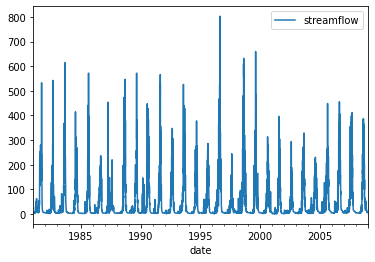

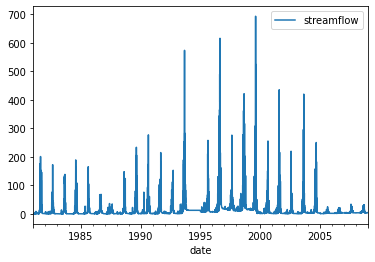

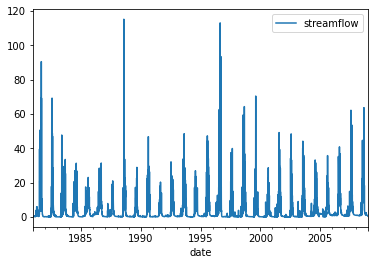

In [ ]:
sf_hom.plot(), sf_akaki.plot(), sf_berga.plot()

#Precipitatin plots

(<matplotlib.axes._subplots.AxesSubplot at 0x7fcf3e97ae90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf3d8d7750>)

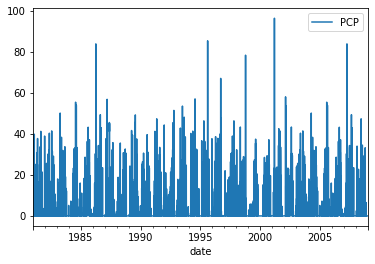

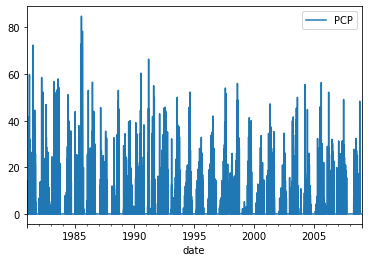

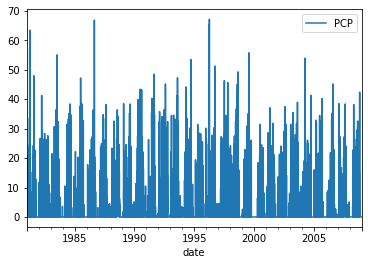

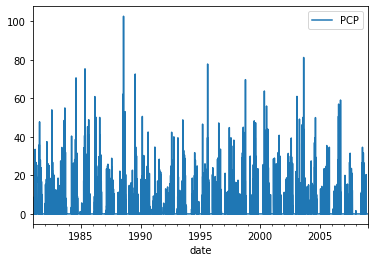

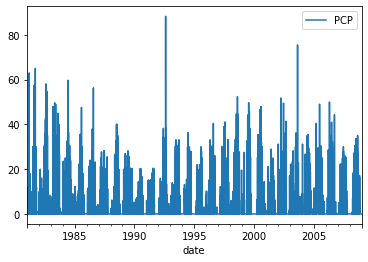

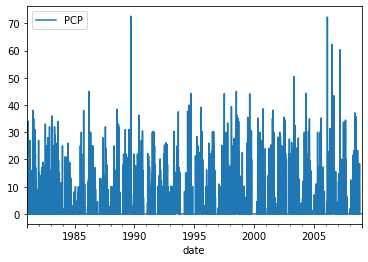

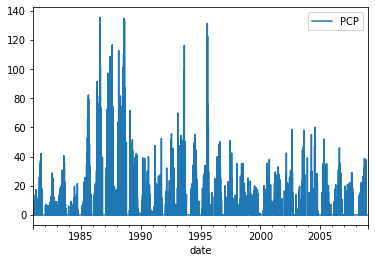

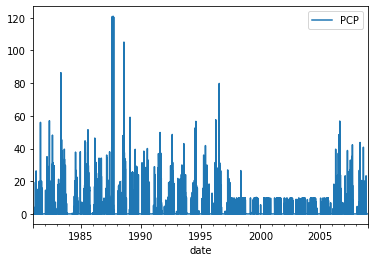

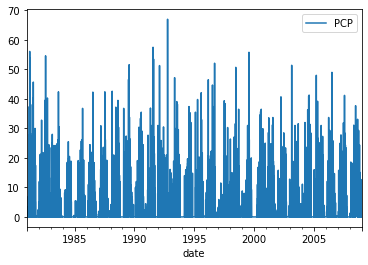

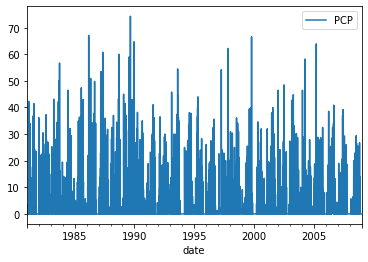

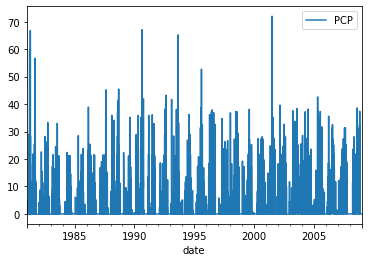

In [ ]:
pcp_aa.plot(), pcp_hom.plot(),pcp_asgori.plot(),pcp_sendefa.plot(),pcp_tulubolo.plot(),pcp_aalem.plot(), pcp_sebeta.plot(),pcp_boneya.plot(),pcp_kimoye.plot(),pcp_ginchi.plot(),pcp_guranda.plot()

#Tempature Plots

(<matplotlib.axes._subplots.AxesSubplot at 0x7fcf3d3df550>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf3bb85f90>)

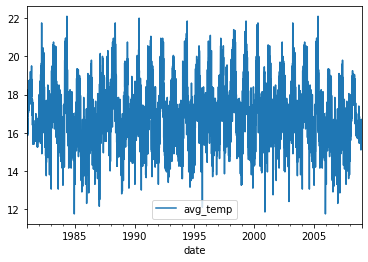

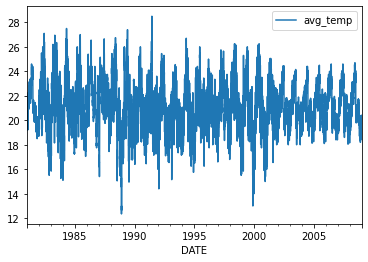

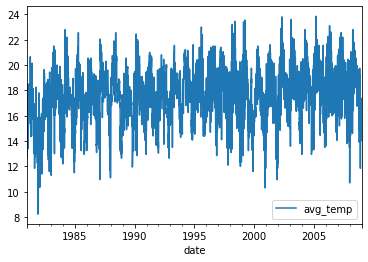

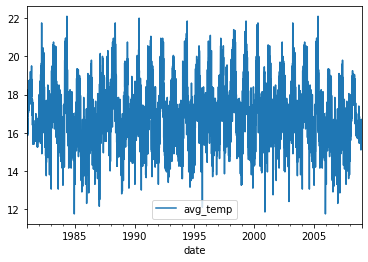

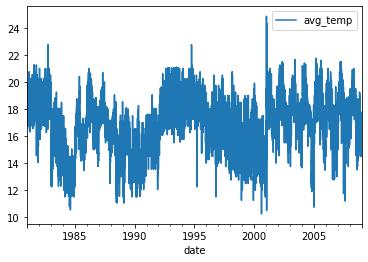

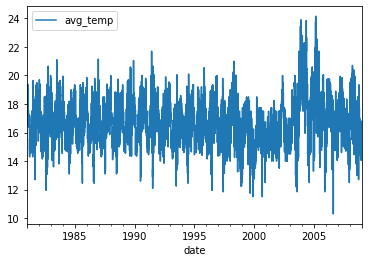

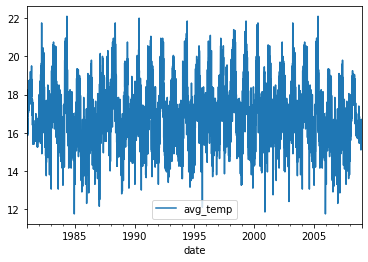

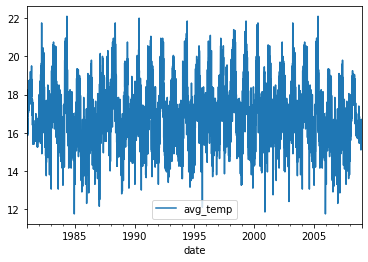

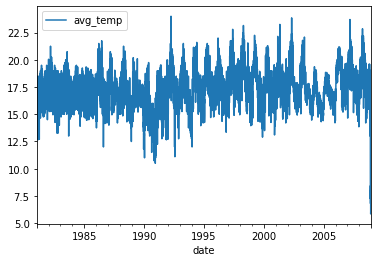

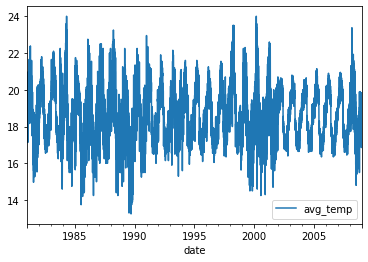

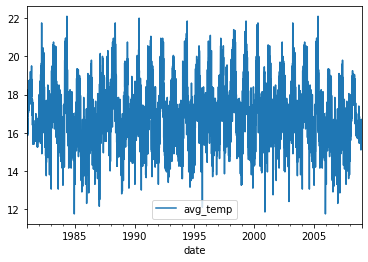

In [ ]:
temp_aa.plot(), temp_hom.plot(),temp_asgori.plot(),temp_sendefa.plot(),temp_tulubolo.plot(),temp_aalem.plot(), temp_sebeta.plot(),temp_boneya.plot(),temp_kimoye.plot(),temp_ginchi.plot(),temp_guranda.plot()

#Humudity Plots

(<matplotlib.axes._subplots.AxesSubplot at 0x7fcf3b788e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf3a6ab690>)

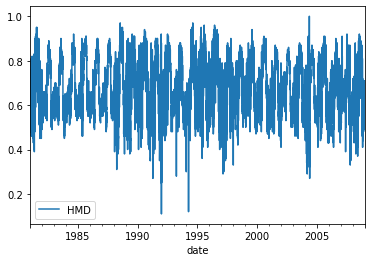

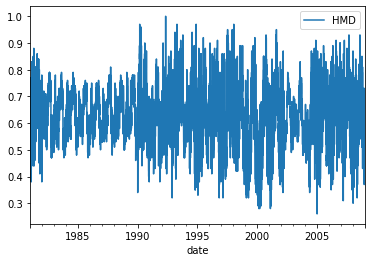

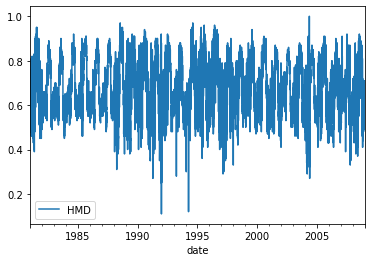

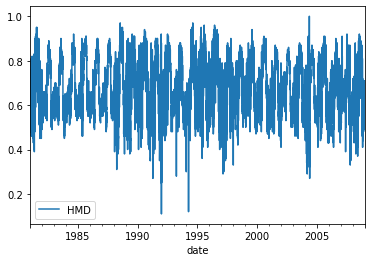

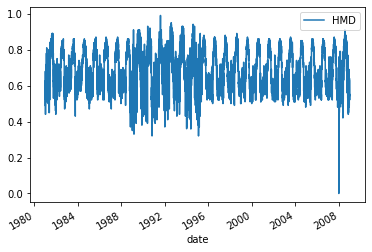

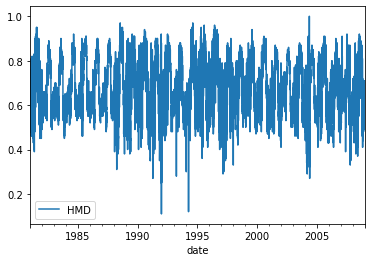

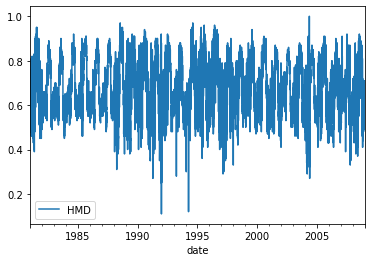

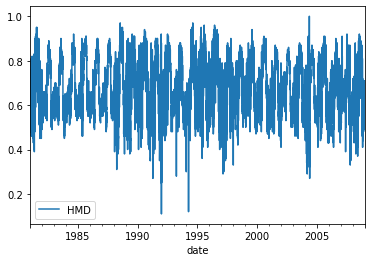

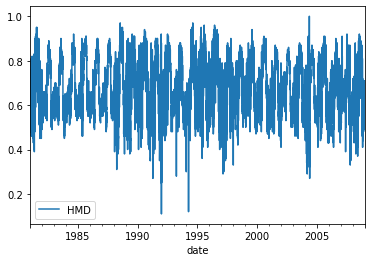

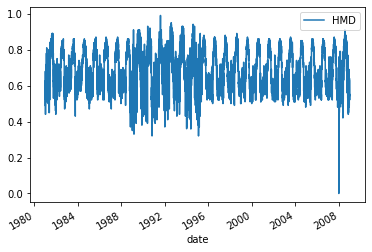

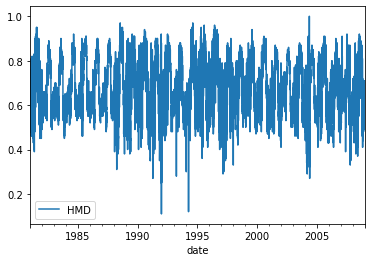

In [ ]:
hmd_aa.plot(), hmd_hom.plot(),hmd_asgori.plot(),hmd_sendefa.plot(),hmd_tulubolo.plot(),hmd_aalem.plot(), hmd_sebeta.plot(),hmd_boneya.plot(),hmd_kimoye.plot(),hmd_ginchi.plot(),hmd_guranda.plot()

#wind plots

(<matplotlib.axes._subplots.AxesSubplot at 0x7fcf3a2817d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf3a3f0d50>)

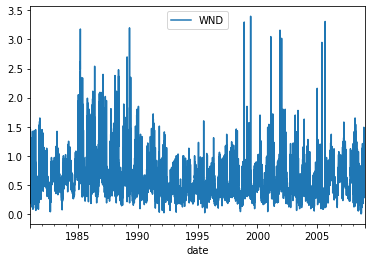

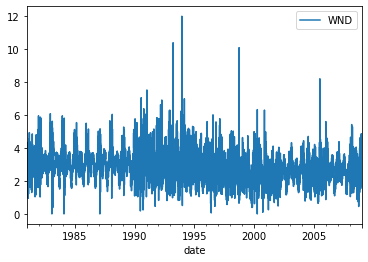

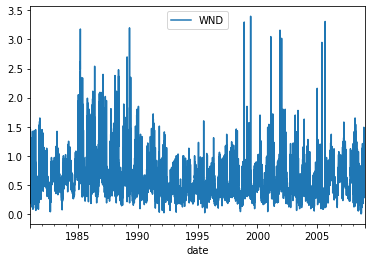

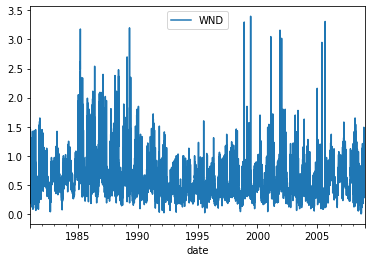

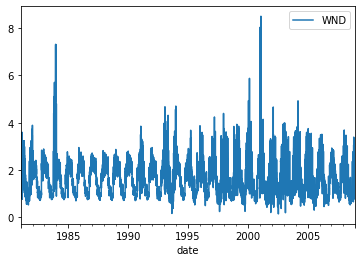

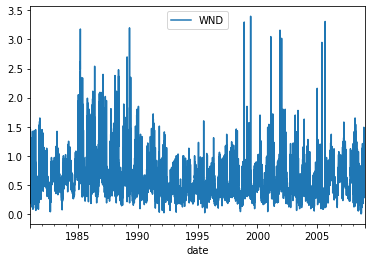

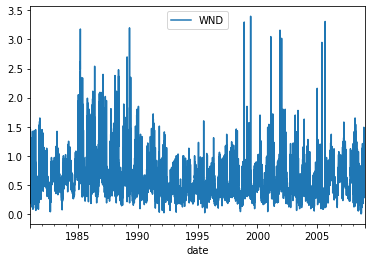

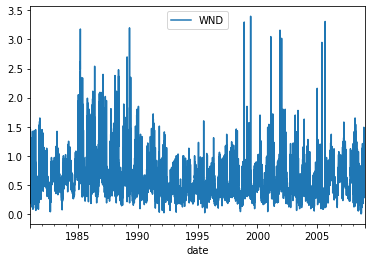

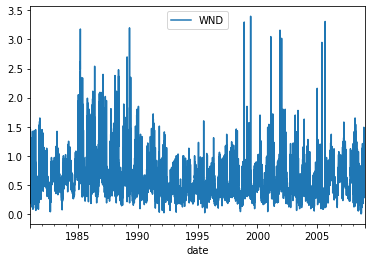

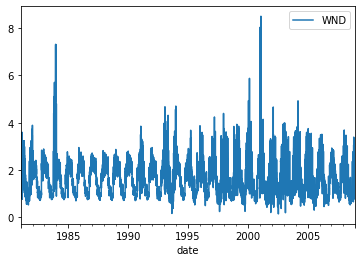

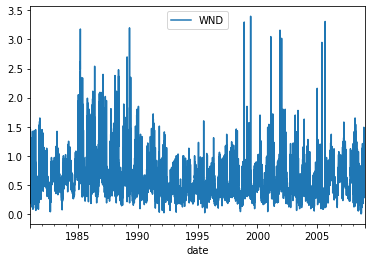

In [ ]:
wnd_aa.plot(),wnd_hom.plot(),wnd_asgori.plot(),wnd_sendefa.plot(),wnd_tulubolo.plot(),wnd_aalem.plot(), wnd_sebeta.plot(),wnd_boneya.plot(),wnd_kimoye.plot(),wnd_ginchi.plot(),wnd_guranda.plot()

#Resampled daily, weekly, monthly and yearly mean value for streamflow at target station

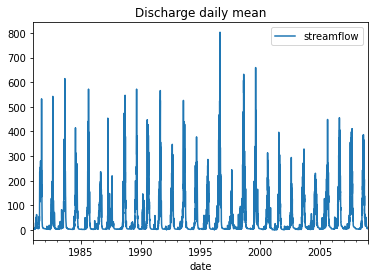

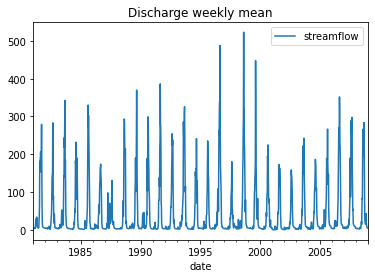

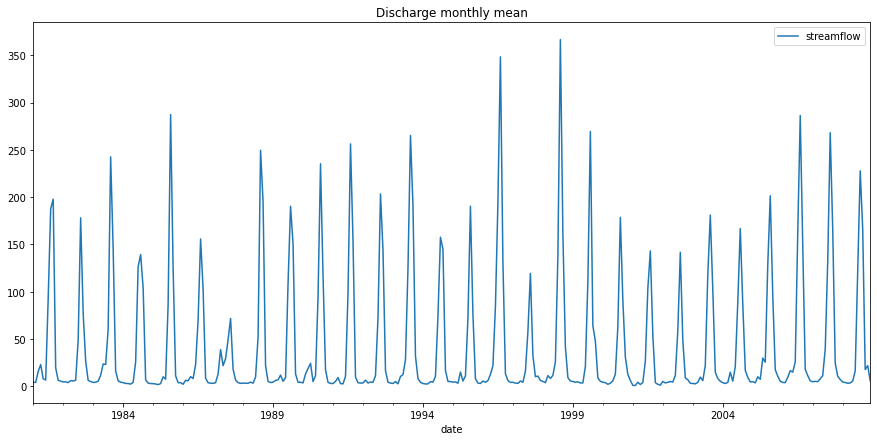

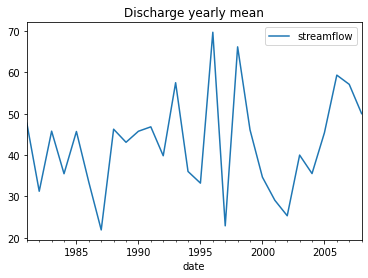

In [ ]:
sf_hom_D = sf_hom.resample('1D').mean()
sf_hom_W = sf_hom.resample('1W').mean()
sf_hom_M = sf_hom.resample('1M').mean()
sf_hom_Y = sf_hom.resample('1Y').mean()


sf_hom_D.plot(title="Discharge daily mean")
sf_hom_W.plot(title="Discharge weekly mean")
sf_hom_M.plot(title="Discharge monthly mean",figsize=(15,7))
sf_hom_Y.plot(title="Discharge yearly mean")

#Autocorrelation for streamflow at 3 different guaging stations

In [ ]:
pd.plotting.autocorrelation_plot(sf_hom['streamflow'])
#ax= pd.plotting.autocorrelation_plot(sf_hom['streamflow'])
#ax.set_xlim([0, 2000])
plt.title("Discharge daily mean")
plt.show()

pd.plotting.autocorrelation_plot(sf_akaki['streamflow'])
plt.title("Discharge weekly mean")
plt.show()

pd.plotting.autocorrelation_plot(sf_berga['streamflow'])
plt.title("Discharge monthly mean")
plt.show()

#from the graphs we can see that there is a corellation between the streamflows and their lags. But after 2000 days the correlation starts to decrease.
# The negative correlation between the time lags is mostly insignificant. This may be due to seasonality of the streamflow---meaning that in one
#season the streamflow may be high and on the next season it will be less 
# The plot also shows seasonality of the data 

In [ ]:
print(len(sf_akaki['streamflow']))
plot_acf(sf_akaki['streamflow'],lags=50)

plot_acf(sf_hom['streamflow'],lags=50)

plot_acf(sf_berga['streamflow'],lags=50)

#Autocorrelation for preciptation at 11 guaging stations 

In [ ]:
#pd.plotting.autocorrelation_plot(pcp_aa['PCP'])
plot_acf(pcp_aa['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_hom['PCP'])
plot_acf(pcp_hom['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_asgori['PCP'])
plot_acf(pcp_asgori['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_sendefa['PCP'])
plot_acf(pcp_sendefa['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_tulubolo['PCP'])
plot_acf(pcp_tulubolo['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_aalem['PCP'])
plot_acf(pcp_aalem['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_boneya['PCP'])
plot_acf(pcp_boneya['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_kimoye['PCP'])
plot_acf(pcp_kimoye['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_sebeta['PCP'])
plot_acf(pcp_sebeta['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_guranda['PCP'])
plot_acf(pcp_guranda['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_ginchi['PCP'])
plot_acf(pcp_ginchi['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#Autocorrelation for temperature at 11 guaging stations

In [ ]:
# pd.plotting.autocorrelation_plot(temp_aa['avg_temp'])
# plt.title("Temperature daily")
# plt.show()

#pd.plotting.autocorrelation_plot(temp_aa['avg_temp'])
plot_acf(temp_aa['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_hom['avg_temp'])
plot_acf(temp_hom['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_asgori['avg_temp'])
plot_acf(temp_asgori['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_sendefa['avg_temp'])
plot_acf(temp_sendefa['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_tulubolo['avg_temp'])
plot_acf(temp_tulubolo['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_aalem['avg_temp'])
plot_acf(temp_aalem['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_boneya['avg_temp'])
plot_acf(temp_boneya['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_kimoye['avg_temp'])
plot_acf(temp_kimoye['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_sebeta['avg_temp'])
plot_acf(temp_sebeta['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_guranda['avg_temp'])
plot_acf(temp_guranda['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_ginchi['avg_temp'])
plot_acf(temp_ginchi['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()


#Autocorrelation for Humudity at 11 guaging stations

In [ ]:
pd.plotting.autocorrelation_plot(hmd_tulubolo['HMD'])
plot_acf(hmd_tulubolo['HMD'],lags=100)
plt.title("humidity daily")
plt.show()

In [ ]:
#pd.plotting.autocorrelation_plot(hmd_ginchi['HMD'])
plot_acf(hmd_ginchi['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#the jumidity at ginchi station does not have any corelation and it is removed from our dataset since it will not help on prediction task.

In [ ]:
# pd.plotting.autocorrelation_plot(hmd_aa['HMD'])
# plt.title("humudirt daily")
# plt.show()

#pd.plotting.autocorrelation_plot(hmd_aa['HMD'])
plot_acf(hmd_aa['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_hom['HMD'])
plot_acf(hmd_hom['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_asgori['HMD'])
plot_acf(hmd_asgori['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_sendefa['HMD'])
plot_acf(hmd_sendefa['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_tulubolo['HMD'])
plot_acf(hmd_tulubolo['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_aalem['HMD'])
plot_acf(hmd_aalem['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_boneya['HMD'])
plot_acf(hmd_boneya['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_kimoye['HMD'])
plot_acf(hmd_kimoye['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_sebeta['HMD'])
plot_acf(hmd_sebeta['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_guranda['HMD'])
plot_acf(hmd_guranda['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_ginchi['HMD'])
plot_acf(hmd_ginchi['HMD'],lags=50)
plt.title("humidity daily")
plt.show()


#Autocorrelation for wind at 11 guaging stations

In [ ]:
# pd.plotting.autocorrelation_plot(wnd_aa['WND'])
# plt.title("wind daily")
# plt.show()

#pd.plotting.autocorrelation_plot(wnd_aa['WND'])
plot_acf(wnd_aa['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_hom['WND'])
plot_acf(wnd_hom['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_asgori['WND'])
plot_acf(wnd_asgori['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_sendefa['WND'])
plot_acf(wnd_sendefa['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_tulubolo['WND'])
plot_acf(wnd_tulubolo['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_aalem['WND'])
plot_acf(wnd_aalem['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_boneya['WND'])
plot_acf(wnd_boneya['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_kimoye['WND'])
plot_acf(wnd_kimoye['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_sebeta['WND'])
plot_acf(wnd_sebeta['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_guranda['WND'])
plot_acf(wnd_guranda['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_ginchi['WND'])
plot_acf(wnd_ginchi['WND'],lags=50)
plt.title("wind daily")
plt.show()


#Data Preparation for univariate input(i.e lagged discharge @ target streamflow guaging station as input and discharge at current time as output) and multiple step output LSTM MODEL

#Supervised data generating function

In [13]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [14]:
# n stations [prcn, prcn-1,...prc1]

#variable declaration

In [15]:
look_back = 15 #Number of time-steps/ time-lags to see before predicting the current 
n_features = 1 # discharge @ target station which is hombole

In [16]:
n_hours = look_back

#1. Training data preparation on year based slicing of pandas dataframe into trainig, validation and test, 20 years data used for training , 4 years data for validation and 4 years data for testing

#Dataframe for univariate multi-step training

In [17]:
raw = DataFrame()
#Temperature features 
# raw['temp_aa'] = temp_aa['avg_temp']
# raw['temp_hom'] = temp_hom['avg_temp']
# raw['temp_asgori'] = temp_asgori['avg_temp']
# raw['temp_sendefa'] = temp_sendefa['avg_temp']
# raw['temp_tulubolo'] = temp_tulubolo['avg_temp']
# raw['temp_aalem'] = temp_aalem['avg_temp']
# raw['temp_boneya'] = temp_boneya['avg_temp']
# raw['temp_kimoye'] = temp_kimoye['avg_temp']
# raw['temp_sebeta'] = temp_sebeta['avg_temp']
# raw['temp_guranda'] = temp_guranda['avg_temp']
# raw['temp_ginchi'] = temp_ginchi['avg_temp']

# # #preciptation features
# raw['rain_aa'] = pcp_aa['PCP']
# raw['rain_hom'] = pcp_hom['PCP']
# raw['rain_asgori'] = pcp_asgori['PCP']
# raw['rain_sendefa'] = pcp_sendefa['PCP']
# raw['rain_tulubolo'] = pcp_tulubolo['PCP']
# raw['rain_aalem'] = pcp_aalem['PCP']
# raw['rain_boneya'] = pcp_boneya['PCP']
# raw['rain_kimoye'] = pcp_kimoye['PCP']
# raw['rain_sebeta'] = pcp_sebeta['PCP']
# raw['rain_guranda'] = pcp_guranda['PCP']
# raw['rain_ginchi'] = pcp_ginchi['PCP']
# # #Humudity features 
# raw['hmd_aa'] = hmd_aa['HMD']
# raw['hmd_hom'] = hmd_hom['HMD']
# raw['hmd_asgori'] = hmd_asgori['HMD']
# raw['hmd_sendefa'] = hmd_sendefa['HMD']
# raw['hmd_tulubolo'] = hmd_tulubolo['HMD']
# raw['hmd_aalem'] = hmd_aalem['HMD']
# raw['hmd_boneya'] = hmd_boneya['HMD']
# raw['hmd_kimoye'] = hmd_kimoye['HMD']
# raw['hmd_sebeta'] = hmd_sebeta['HMD']
# raw['hmd_guranda'] = hmd_guranda['HMD']
# raw['hmd_ginchi'] = hmd_ginchi['HMD']

# # #Wind features 
# raw['wnd_aa'] = wnd_aa['WND']
# raw['wnd_hom'] = wnd_hom['WND']
# raw['wnd_asgori'] = wnd_asgori['WND']
# raw['wnd_sendefa'] = wnd_sendefa['WND']
# raw['wnd_tulubolo'] = wnd_tulubolo['WND']
# raw['wnd_aalem'] = wnd_aalem['WND']
# raw['wnd_boneya'] = wnd_boneya['WND']
# raw['wnd_kimoye'] = wnd_kimoye['WND']
# raw['wnd_sebeta'] = wnd_sebeta['WND']
# raw['wnd_guranda'] = wnd_guranda['WND']
# raw['wnd_ginchi'] = wnd_ginchi['WND']

# #Streamflow features
# raw['Q_akaki'] = sf_akaki['streamflow']
# raw['Q_berga'] = sf_berga['streamflow']
raw['Q_hom'] = sf_hom['streamflow']
  

values2 = raw.values
 

#Training data partition (1981 - 2000)

In [18]:
raw_train= raw.loc['1981-01-01':'2000-12-31']
values_train = raw_train.values

#Validation data partition (2001 - 2004)

In [19]:
raw_val = raw.loc['2001-01-01':'2004-12-31']
values_val = raw_val.values

#Test data partition (2004 - 2008)

In [20]:
raw_test = raw.loc['2005-01-01':'2008-12-31']
values_test = raw_test.values

#Generating Supervised data for train, valid and test

In [21]:
sup_train = series_to_supervised(values_train, n_hours, 3) 

print(sup_train.shape)

(7288, 18)


In [22]:
sup_val = series_to_supervised(values_val, n_hours, 3) 

print(sup_val.shape)

(1444, 18)


In [23]:
sup_test = series_to_supervised(values_test, n_hours, 3) 

print(sup_test.shape)

(1444, 18)


#Train, validation and Test split

In [24]:
train = sup_train.values
val = sup_val.values
test = sup_test.values

In [25]:
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, [15,16,17]]
test_X, test_y = test[:, :n_obs], test[:, [15,16,17]]
val_X, val_y = val[:, :n_obs], val[:, [15,16,17]]
print(train_X.shape, len(train_X), train_y.shape)
print(test_X.shape, len(test_X), test_y.shape)
print(val_X.shape, len(val_X), val_y.shape)

(7288, 15) 7288 (7288, 3)
(1444, 15) 1444 (1444, 3)
(1444, 15) 1444 (1444, 3)


#2. Training data prepartion by randomly classifying the whole data into train, validation and test

#Data frame after data is converted to supervised format for multi-step output

In [ ]:
reframed = series_to_supervised(values2, n_hours, 3) 

print(reframed.shape)

(10215, 13)


In [ ]:
reframed

#Train, Validation and Test split

In [ ]:
values_2 = reframed.values
TRAIN_SIZE = 0.8
n_train = int(len(values_2) * TRAIN_SIZE) 
train = values_2[:n_train, :]
eval = values_2[n_train:, :]

In [ ]:
TEST_SIZE = 0.5
n_val= int(len(eval) * TEST_SIZE) 
val = eval[:n_val, :]
test = eval[n_val:, :]

In [ ]:
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:,  [10,11,12]]
test_X, test_y = test[:, :n_obs], test[:,  [10,11,12]]
val_X, val_y = val[:, :n_obs], val[:,  [10,11,12]]
print(train_X.shape, len(train_X), train_y.shape)
print(test_X.shape, len(test_X), test_y.shape)
print(val_X.shape, len(val_X), val_y.shape)

(8172, 10) 8172 (8172, 3)
(1022, 10) 1022 (1022, 3)
(1021, 10) 1021 (1021, 3)


#Feature scaling (the next part of code will work for both approaches described above as 1) and 2) )

In [26]:
# feature scaling
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train = scaler_X.fit_transform(train_X)

scaler_Y = MinMaxScaler(feature_range=(0, 1))
Y_train = scaler_Y.fit_transform(train_y)

In [27]:
X_test = scaler_X.transform(test_X)
Y_test = scaler_Y.transform(test_y)

X_val = scaler_X.transform(val_X)
Y_val = scaler_Y.transform(val_y)

#Reshaping train, validation and test data into 3D shape since LSTM takes as input a data in the format (samples, time-step, sample_features)

In [28]:
train_X2 = X_train.reshape((X_train.shape[0], n_hours, n_features))
test_X2 = X_test.reshape((X_test.shape[0], n_hours, n_features))
val_X2 = X_val.reshape((X_val.shape[0], n_hours, n_features))
print(train_X2.shape, train_y.shape, test_X2.shape, test_y.shape,val_X2.shape, val_y.shape)

(7288, 15, 1) (7288, 3) (1444, 15, 1) (1444, 3) (1444, 15, 1) (1444, 3)


In [29]:
# train_y2 = Y_train.reshape((Y_train.shape[0], 1, 1))
# test_y2 = Y_test.reshape((Y_test.shape[0], 1, 1))
# val_y2 = Y_val.reshape((Y_val.shape[0], 1, 1))
# print(train_X2.shape, train_y2.shape, test_X2.shape, test_y2.shape,val_X2.shape, val_y2.shape)

train_y2 = Y_train
test_y2 = Y_test
val_y2 = Y_val
print(train_X2.shape, train_y2.shape, test_X2.shape, test_y2.shape,val_X2.shape, val_y2.shape)

(7288, 15, 1) (7288, 3) (1444, 15, 1) (1444, 3) (1444, 15, 1) (1444, 3)


#Model setup without using Gridsearch algorithm

In [ ]:
def nse_loss(y_true, y_pred):
    """
    Custom metric function to calculate the Nash-Sutcliffe model efficientcy coefficient
    From: https://en.wikipedia.org/wiki/Nash%E2%80%93Sutcliffe_model_efficiency_coefficient
    Commonly used in hydrology to evaluate a model performance (NSE > 0.7 is good)
    
    Args:
        y_true: Tensor with true values from observations/labels
        y_pred: Tensor of predicted values from model
    Returns: 
       tf.Tensor of the inverted NSE value
    """
    numer = K.sum(K.pow(y_true-y_pred,2))
    denom = K.sum(K.pow(y_true-K.mean(y_true),2)) + K.epsilon()
    nse = (1 - (numer/denom))
    return -1*nse

In [30]:
#opt = tf.keras.optimizers.SGD(learning_rate=0.01)
#opt = tf.keras.optimizers.Adamax(learning_rate=0.001)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
#opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)

In [54]:
model2 = Sequential()
model2.add(LSTM(100, input_shape=(train_X2.shape[1], train_X2.shape[2]), return_sequences=True, activation='relu'))
#model2.add(LSTM(50, input_shape=(train_X2.shape[1], train_X2.shape[2]),  activation='relu'))
#model2.add(Dropout(0.25)) # Dropout regularisation
model2.add(LSTM(100,  activation='relu'))
#model2.add(Dropout(0.25)) # Dropout regularisation
model2.add(Dense(3))
#model2.compile(loss=nse_loss, optimizer='adam', metrics=['mae','mse'])
model2.compile(loss='mse', optimizer=opt, metrics=['mae','mse'])

#optimizer='rmsprop',

In [66]:
model2 = Sequential()
model2.add(Bidirectional(   LSTM(50, activation='relu', return_sequences=True),   input_shape=(train_X2.shape[1], train_X2.shape[2])    ))
#model2.add(Bidirectional(   LSTM(100, activation='relu'),   input_shape=(train_X2.shape[1], train_X2.shape[2])    ))
#model2.add(Dropout(0.25)) # Dropout regularisation
model2.add(Bidirectional(   LSTM(50, activation='relu')    ))
#model2.add(Dropout(0.25)) # Dropout regularisation
model2.add(Dense(3))
model2.compile(loss= 'mse', optimizer=opt, metrics=['mae','mse'])

#Train the model

In [67]:
history2 = model2.fit(train_X2, train_y2, epochs=50, batch_size=100, validation_data=(val_X2, val_y2), verbose=1, shuffle=False)

Epoch 1/50
73/73 [==============================] - 11s 111ms/step - loss: 0.0034 - mae: 0.0293 - mse: 0.0034 - val_loss: 0.0011 - val_mae: 0.0154 - val_mse: 0.0011
Epoch 2/50
73/73 [==============================] - 8s 103ms/step - loss: 0.0022 - mae: 0.0208 - mse: 0.0022 - val_loss: 0.0010 - val_mae: 0.0149 - val_mse: 0.0010
Epoch 3/50
73/73 [==============================] - 7s 102ms/step - loss: 0.0021 - mae: 0.0198 - mse: 0.0021 - val_loss: 9.9551e-04 - val_mae: 0.0140 - val_mse: 9.9551e-04
Epoch 4/50
73/73 [==============================] - 8s 104ms/step - loss: 0.0020 - mae: 0.0192 - mse: 0.0020 - val_loss: 9.7622e-04 - val_mae: 0.0137 - val_mse: 9.7622e-04
Epoch 5/50
73/73 [==============================] - 9s 127ms/step - loss: 0.0019 - mae: 0.0187 - mse: 0.0019 - val_loss: 9.7141e-04 - val_mae: 0.0136 - val_mse: 9.7141e-04
Epoch 6/50
73/73 [==============================] - 8s 104ms/step - loss: 0.0019 - mae: 0.0184 - mse: 0.0019 - val_loss: 9.7138e-04 - val_mae: 0.0136 - val

#Model setup using Gridsearch for parameter optimization

In [ ]:
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50, input_shape=(train_X2.shape[1], train_X2.shape[2]), activation='relu'))
    #grid_model.add(LSTM(50,return_sequences=True,input_shape=(10,23)))
    #grid_model.add(LSTM(50))
    #grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model
    
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(test_X2, test_y2))

parameters = {'batch_size' : [8, 16,32,64,128,256],
              'epochs' : [10,20,30,50,70,90,120,150,200],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  if sys.path[0] == '':


#Train the model using gridsearch approach

In [ ]:
grid_search = grid_search.fit(train_X2, train_y2)
#started training @9:36 AM

#Check best parameters of the model

In [ ]:
grid_search.best_params_

#Save the best model in my_ In the model variable.

In [ ]:
my_model=grid_search.best_estimator_.model

#plot train and valid loss for multi-step output

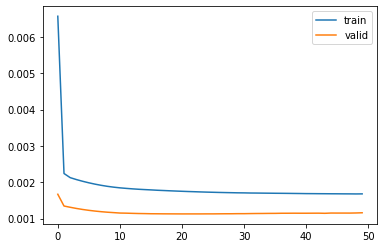

In [ ]:
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='valid')
plt.legend()
plt.show()

#prediction for test dataset

In [68]:
yhat2 = model2.predict(test_X2)
test_X2 = test_X2.reshape((test_X2.shape[0], n_hours*n_features))


inv_yhat2 = scaler_Y.inverse_transform(yhat2)
orig = test_y2 = test_y2.reshape((len(test_y2), 3))
inv_y2 = scaler_Y.inverse_transform(orig)

#RMSE calculator for multi-step output case

In [35]:
# the code is taken from https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/
def evaluate_forecasts_mse(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2

	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [36]:
# the code is taken from https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/
def evaluate_forecasts_mae(actual, predicted):
	scores2 = list()
	# calculate an MAE score for each day
	for i in range(actual.shape[1]):
		# calculate mae
		mae = mean_absolute_error(actual[:, i], predicted[:, i])
		mae = sqrt(mae)**2
		# store
		scores2.append(mae)
	# calculate overall MAE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += abs(actual[row, col] - predicted[row, col])
			s= sqrt(s)**2
	score2 = s / (actual.shape[0] * actual.shape[1])
	return score2, scores2

In [37]:
# the code is taken from https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/
def evaluate_forecasts_nse(actual, predicted):
  scores = list()
  # calculate an NSE score for each day
  for i in range(actual.shape[1]):
    nse = 1-(np.sum(np.power((actual[:, i]-predicted[:, i]),2))/np.sum(np.power((actual[:, i]-actual[:, i].mean()),2)))
    # store
    nse= sqrt(nse)**2
    scores.append(nse)
  # calculate overall NSE
  s1 = 0
  s2= 0
  m= (actual[:, 0].mean() + actual[:, 1].mean() + actual[:, 1].mean()) / 3
  for row in range(actual.shape[0]):
    for col in range(actual.shape[1]):
      s1 += np.power((actual[row, col]-predicted[row, col]),2)
      s2 += np.power((actual[row, col]- m),2)
      s1= sqrt(s1)**2
      s2 = sqrt(s2)**2

  score = 1- (s1/s2)
  return score, scores

#RMSE score values for individual days and the cummulative RMSE value for (t+n) prediciton days

In [38]:
%precision %.2f

'%.2f'

In [69]:
score, scores = evaluate_forecasts_mse(inv_y2, inv_yhat2)
score, scores

(32.56, [27.99, 33.30, 35.89])

In [70]:
score, scores = evaluate_forecasts_mae(inv_y2, inv_yhat2)
score, scores

(15.69, [13.72, 16.00, 17.36])

In [71]:
score, scores = evaluate_forecasts_nse(inv_y2, inv_yhat2)
score, scores

(0.86, [0.90, 0.85, 0.83])

#Plot predicted vs original test dataset for multi-step output

inv_y2 (OBS) max: 455.706  versus inv_yhat2 (SIM) max: 406.4872


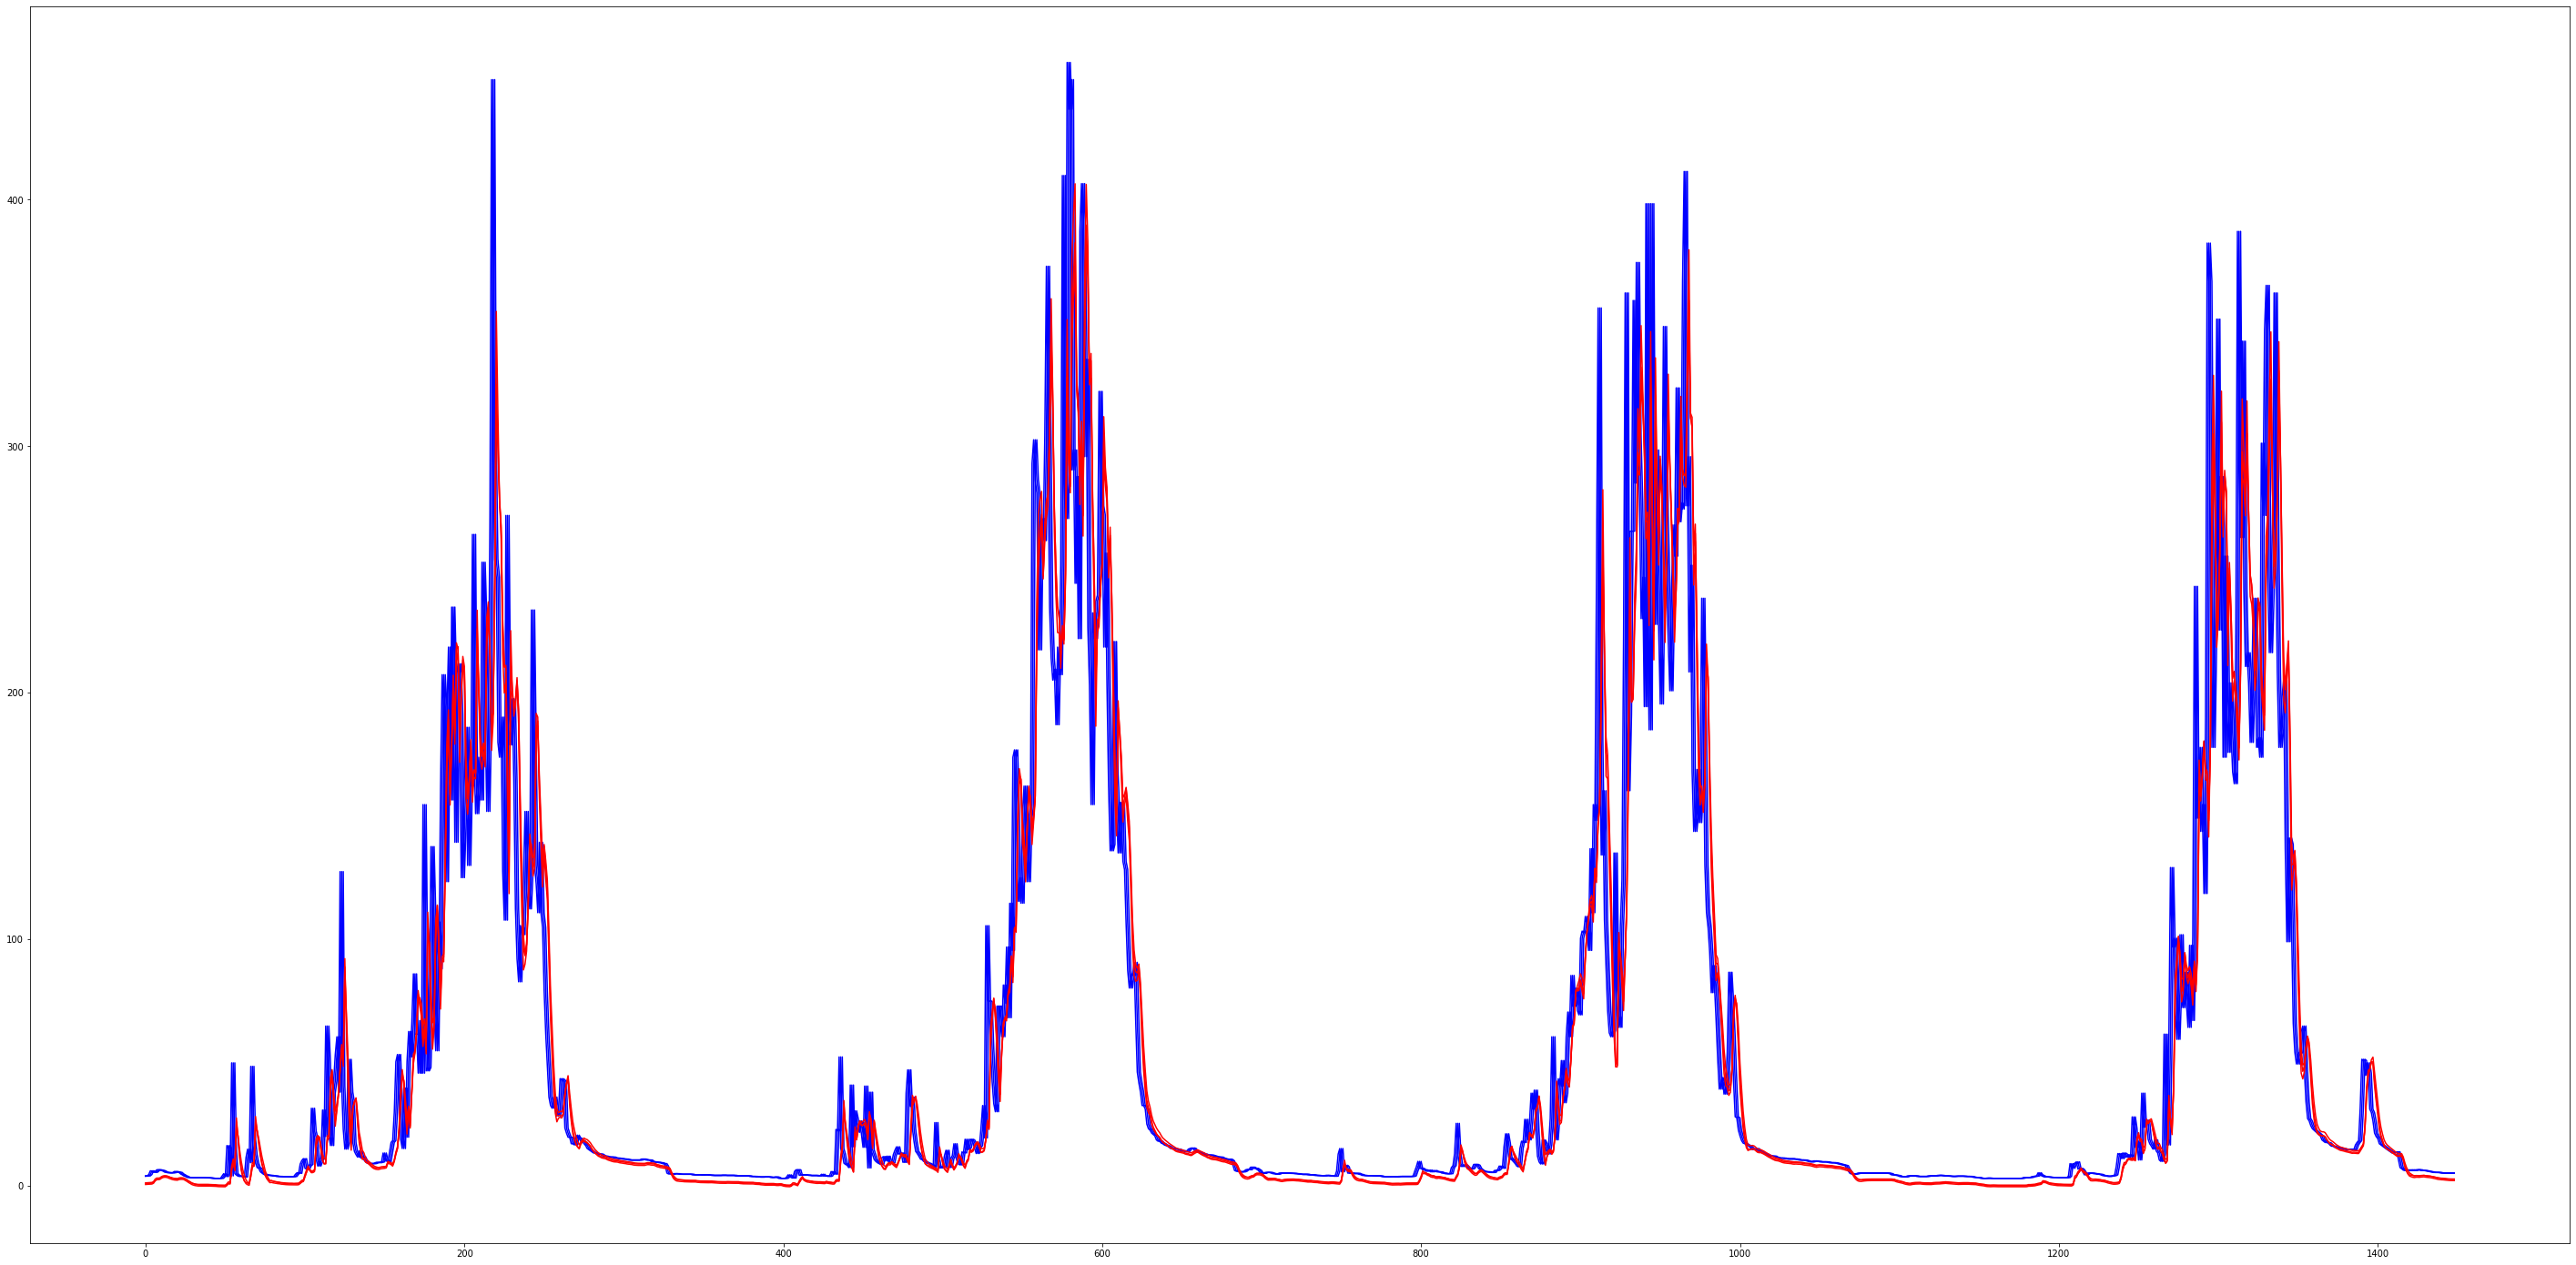

In [ ]:
print('inv_y2 (OBS) max:',np.max(inv_y2),' versus inv_yhat2 (SIM) max:',np.max(inv_yhat2))
plt.figure(figsize=(50,25))
plt.plot(inv_y2, color='blue')
plt.plot(inv_yhat2,color='red')
plt.show()

In [ ]:
df_inv_y2 = pd.DataFrame(data=inv_y2,index=raw2.index,columns=['inv_y2'])
df_inv_yhat2 = pd.DataFrame(data=inv_yhat2,index=raw2.index,columns=['inv_yhat2'])

fig, ax = plt.subplots(1,1, figsize=(20,10))

# x axis to plot both runoff and precip. against
x = df_inv_y2.index

ax.plot(x, df_inv_y2, color="blue", label='Observed Discharge')
ax.plot(x, df_inv_yhat2,color='black', label='Predicted Discharge')



# Create second axes, in order to get the bars from the top you can multiply 
# by -1
ax2 = ax.twinx()
ax2.bar(x, -raw2['rain'], color="gray", label='Rain')
ax2.bar(x, -df_snow['snow'], color="red", label='Snow')

# Now need to fix the axis labels
max_pre = np.int(np.trunc(max(raw2['rain']))+10)
y2_ticks = np.linspace(0, max_pre, max_pre+1)
y2_ticklabels = [str(i) for i in y2_ticks]
ax2.set_yticks(-1 * y2_ticks)
ax2.set_yticklabels(y2_ticklabels)

handles2, labels2 = ax2.get_legend_handles_labels()
handles, labels = ax.get_legend_handles_labels()
ax2.legend(handles2 + handles, labels2 + labels, loc='upper left', frameon=False)

ax.set_ylim([0,0.2])
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Discharge [cmps]', fontsize=14)
ax2.set_ylabel('Precipitation [mm]', fontsize=14)

plt.title('LSTM-ANN Model 2 v.2 Batchsize 8760',fontsize=20, color = 'black')

plt.show()

NameError: ignored